In [40]:
import numpy as np
from ipywidgets import interact, widgets

F = 96485 #Faraday constant (C/mol)
R = 8.314 #Gas constant (J/mol·K)
H2_M = 2.016e-3 #kg/mol
H2O_M = 18.015e-3 #kg/mol

In [41]:
def membrane_temperature(heater_temp, distance, k, heat_flux=5000):
    temp_drop = heat_flux * distance / k #Fourier Law of conduction
    T_mem = heater_temp - temp_drop
    return max(T_mem, 273.15)

In [42]:
def nernst_voltage(T, pressure, h2_util=0.85, o2_util=0.5):
    E0 = 1.229
    p_H2 = pressure * (1 - h2_util)
    p_O2 = pressure * (1 - o2_util)
    p_H2O = pressure * 0.5
    if p_H2 <= 0 or p_O2 <= 0 or p_H2O <= 0:
        return E0
    nernst = (R * T) / (2 * F) #simplified Nernst equation
    return E0 + nernst * np.log((p_H2 * np.sqrt(p_O2)) / p_H2O)

In [43]:
def current_density(thickness, T, pressure, base_cond=10):
    temp_factor = np.exp((T - 353) / 50) #Arrhenius equation
    press_factor = np.sqrt(pressure)
    conductivity = base_cond * temp_factor * press_factor
    resistance = thickness / conductivity
    j = 1000 / (resistance + 1e-4)  # avoid singularity
    return np.clip(j, 0, 20000)

In [44]:
def hydrogen_consumption(h2_flow, j, area, util=0.85):
    I = j * area
    mol_rate = (I / (2 * F)) * util #Faraday's Law
    needed = mol_rate * H2_M
    available = h2_flow * util
    return min(needed, available)

In [45]:
def fuel_cell_outputs(
    heater_temp=400,
    distance=0.01,
    k=1.5,
    h2_flow=1e-5,
    o2_flow=8e-5,
    thickness=2e-4,
    pressure=3,
    area=0.01,
    hours=8000
):
    """Return: membrane T, yearly energy, yearly H2O, power"""
    
    T_mem = membrane_temperature(heater_temp, distance, k) #thermal

    E_nernst = nernst_voltage(T_mem, pressure) #electrochem 
    j = current_density(thickness, T_mem, pressure)

    h2_used = hydrogen_consumption(h2_flow, j, area) #h2 production
    I = j * area
    voltage = max(E_nernst - 0.3, 0.4)
    power = I * voltage #power

    annual_energy = power * hours / 1000 #energy

    mol_H2 = h2_used / H2_M
    mol_H2O = mol_H2
    h2o_rate = mol_H2O * H2O_M
    annual_h2o = h2o_rate * hours * 3600 #water product

    return T_mem, annual_energy, annual_h2o, power

In [46]:
@interact(
    heater_temp=widgets.FloatSlider(value=400, min=350, max=500, step=10),
    distance=widgets.FloatSlider(value=0.01, min=0.005, max=0.05, step=0.005),
    k=widgets.FloatSlider(value=1.5, min=0.5, max=5, step=0.5),
    h2_flow=widgets.FloatSlider(value=1.0, min=0.1, max=5, step=0.1),
    o2_flow=widgets.FloatSlider(value=8.0, min=1, max=20, step=1),
    thickness=widgets.FloatSlider(value=200, min=50, max=500, step=50),
    pressure=widgets.FloatSlider(value=3.0, min=1, max=10, step=0.5),
)
def show_results(heater_temp, distance, k, h2_flow, o2_flow, thickness, pressure):
    h2_flow *= 1e-5
    o2_flow *= 1e-5
    thickness *= 1e-6

    T, E, W, P = fuel_cell_outputs(
        heater_temp=heater_temp,
        distance=distance,
        k=k,
        h2_flow=h2_flow,
        o2_flow=o2_flow,
        thickness=thickness,
        pressure=pressure
    )

    print("-" * 60)
    print("Fuel Cell Outputs")
    print("-" * 60)
    print(f"Membrane Temperature: {T:.2f} K ({T-273.15:.1f} °C)")
    print(f"Power:               {P:.2f} W")
    print(f"Energy (annual):     {E:.2f} kWh/year")
    print(f"H2O production:      {W:.2f} kg/year")
    print("-" * 60)

interactive(children=(FloatSlider(value=400.0, description='heater_temp', max=500.0, min=350.0, step=10.0), Fl…

In [47]:
import matplotlib.pyplot as plt

number_sims = 1000

mc_heater_temp = np.random.uniform(350, 500, number_sims)
mc_distance    = np.random.uniform(0.005, 0.05, number_sims)
mc_k           = np.random.uniform(0.5, 5, number_sims)
mc_h2_flow     = np.random.uniform(0.1e-5, 5e-5, number_sims)
mc_o2_flow     = np.random.uniform(1e-5, 20e-5, number_sims)
mc_thickness   = np.random.uniform(50e-6, 500e-6, number_sims)
mc_pressure    = np.random.uniform(1, 10, number_sims)

P_out = np.zeros(number_sims)

for i in range(number_sims):
    _, _, _, P = fuel_cell_outputs(
        heater_temp=mc_heater_temp[i],
        distance=mc_distance[i],
        k=mc_k[i],
        h2_flow=mc_h2_flow[i],
        o2_flow=mc_o2_flow[i],
        thickness=mc_thickness[i],
        pressure=mc_pressure[i],
    )
    P_out[i] = P

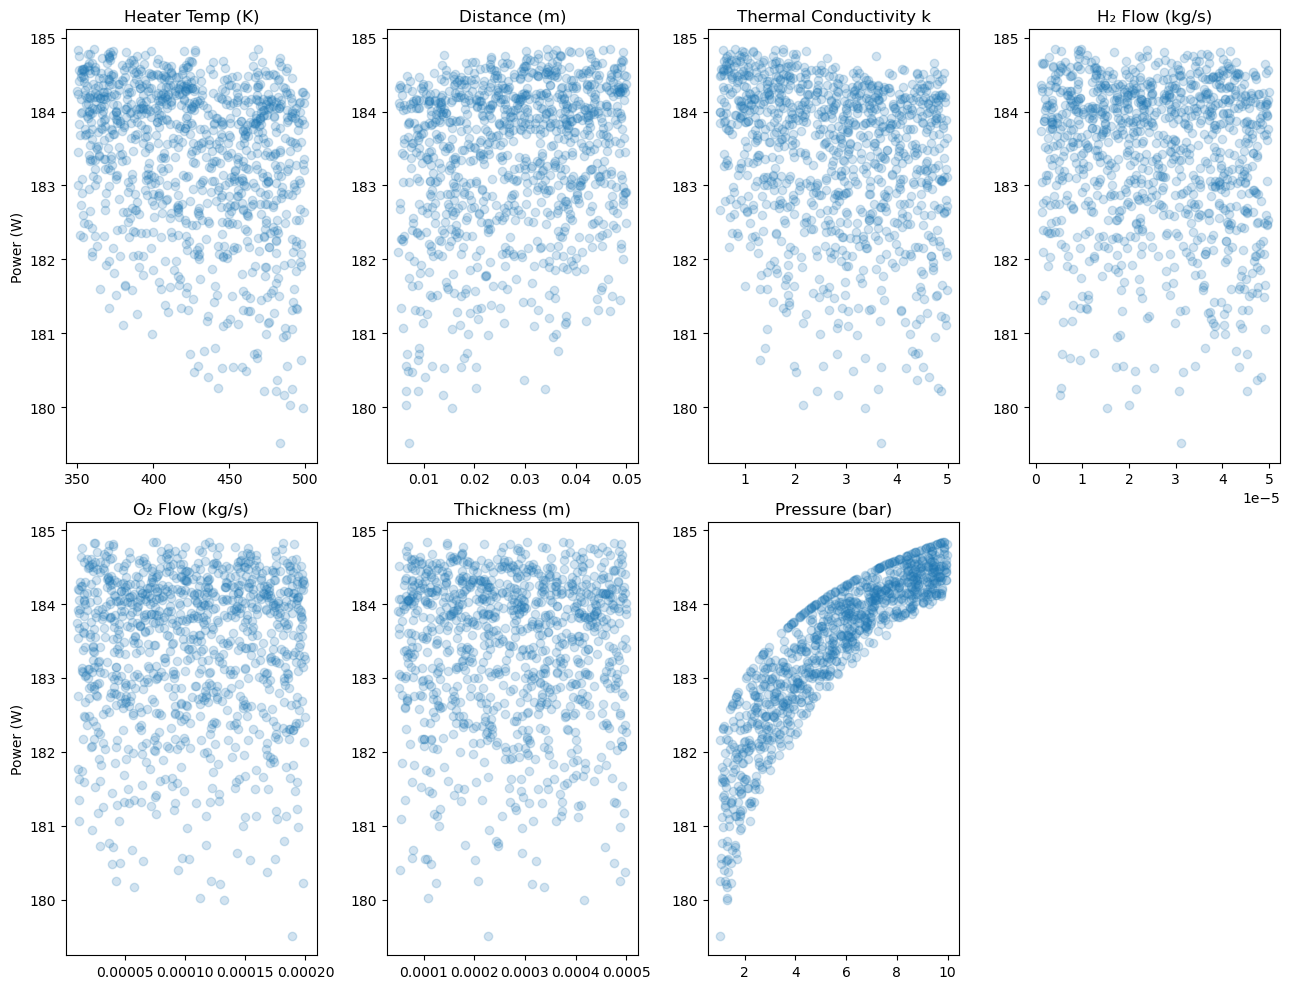

In [48]:
plt.figure(figsize=(13,10))

plt.subplot(241)
plt.scatter(mc_heater_temp, P_out, alpha=0.2)
plt.title("Heater Temp (K)")
plt.ylabel("Power (W)")

plt.subplot(242)
plt.scatter(mc_distance, P_out, alpha=0.2)
plt.title("Distance (m)")

plt.subplot(243)
plt.scatter(mc_k, P_out, alpha=0.2)
plt.title("Thermal Conductivity k")

plt.subplot(244)
plt.scatter(mc_h2_flow, P_out, alpha=0.2)
plt.title("H₂ Flow (kg/s)")

plt.subplot(245)
plt.scatter(mc_o2_flow, P_out, alpha=0.2)
plt.title("O₂ Flow (kg/s)")
plt.ylabel("Power (W)")

plt.subplot(246)
plt.scatter(mc_thickness, P_out, alpha=0.2)
plt.title("Thickness (m)")

plt.subplot(247)
plt.scatter(mc_pressure, P_out, alpha=0.2)
plt.title("Pressure (bar)")

plt.tight_layout()
plt.show()